In [10]:
# read source csv generated by Bryan
import pandas as pd
census_df = pd.read_csv('../data/census_data.csv')
city_df = pd.read_csv('../data/city_coordinates.csv')

census_df.head(), city_df.head()

(                       NAME  S1903_C03_001E  state  place
 0      Auburn city, Alabama           54839      1   3076
 1  Birmingham city, Alabama           39326      1   7000
 2      Dothan city, Alabama           53929      1  21184
 3      Hoover city, Alabama          103194      1  35896
 4  Huntsville city, Alabama           68930      1  37000,
                        City   Latitude  Longitude
 0      Auburn city, Alabama  32.601014 -85.516657
 1  Birmingham city, Alabama  33.599853 -86.632216
 2      Dothan city, Alabama  31.221808 -85.378001
 3      Hoover city, Alabama  33.387197 -86.805680
 4  Huntsville city, Alabama  34.729847 -86.585901)

In [11]:
# merge data and some cleaning
df = census_df.merge(city_df, left_on='NAME', right_on='City')
df.drop_duplicates(inplace=True)
df.rename(columns={'S1903_C03_001E': 'Med_Inc'}, inplace=True)
df = df[['City', 'Med_Inc', 'Latitude', 'Longitude']]

df.head(), len(df)

(                        City  Med_Inc   Latitude  Longitude
 0       Auburn city, Alabama    54839  32.601014 -85.516657
 4   Birmingham city, Alabama    39326  33.599853 -86.632216
 8       Dothan city, Alabama    53929  31.221808 -85.378001
 12      Hoover city, Alabama   103194  33.387197 -86.805680
 16  Huntsville city, Alabama    68930  34.729847 -86.585901,
 646)

In [14]:
# Import dependencies and API key
import requests, json
from lc_key import geoapify_key

# Set parameters 
radius, limit = 5000, 100  
categories = "catering.bar, catering.pub, catering.biergarten, catering.taproom"

print("Search liquor store within 5000m radius...")

# Iterate through the DataFrame to get liquor store counts for all cities
for index, row in df.iterrows():
    lat, lon = row['Latitude'], row['Longitude']  

    params = {"apiKey": geoapify_key,
              "categories": categories,
              "filter": f"circle:{lon},{lat},{radius}",
              "bias": f"proximity:{lon},{lat}",
              "limit": limit}

    url = "https://api.geoapify.com/v2/places"
    data = requests.get(url, params=params).json()
   
    # Count the number of bars
    try:
        df.loc[index, "Lqr_Str"] = len(data["features"])
    except (KeyError, IndexError):
        df.loc[index, "Lqr_Str"] = 0
    
    print(f"    {row['City']}: found {int(df.loc[index, 'Lqr_Str'])}")


Search liquor store within 5000m radius...
    Auburn city, Alabama: found 4
    Birmingham city, Alabama: found 2
    Dothan city, Alabama: found 1
    Hoover city, Alabama: found 2
    Huntsville city, Alabama: found 30
    Mobile city, Alabama: found 11
    Montgomery city, Alabama: found 7
    Tuscaloosa city, Alabama: found 18
    Anchorage municipality, Alaska: found 22
    Avondale city, Arizona: found 0
    Buckeye city, Arizona: found 0
    Casas Adobes CDP, Arizona: found 3
    Chandler city, Arizona: found 20
    Flagstaff city, Arizona: found 6
    Gilbert town, Arizona: found 13
    Glendale city, Arizona: found 4
    Goodyear city, Arizona: found 1
    Maricopa city, Arizona: found 0
    Mesa city, Arizona: found 21
    Peoria city, Arizona: found 3
    Phoenix city, Arizona: found 61
    Queen Creek town, Arizona: found 2
    San Tan Valley CDP, Arizona: found 1
    Scottsdale city, Arizona: found 34
    Surprise city, Arizona: found 2
    Tempe city, Arizona: found 26
 

In [32]:
# save data as csv file
df.to_csv("../data/city_liquor.csv", header=True, index=False)
df.head()

,City,Med_Inc,Latitude,Longitude,Lqr_Str
0,"Auburn city, Alabama",54839,32.601014,-85.516657,4.0
4,"Birmingham city, Alabama",39326,33.599853,-86.632216,2.0
8,"Dothan city, Alabama",53929,31.221808,-85.378001,1.0
12,"Hoover city, Alabama",103194,33.387197,-86.805680,2.0
16,"Huntsville city, Alabama",68930,34.729847,-86.585901,30.0


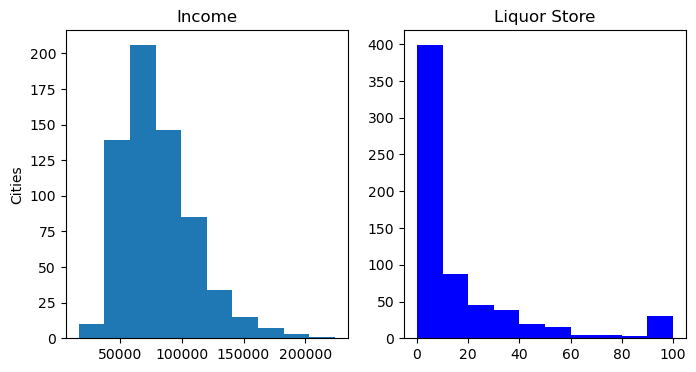

In [33]:
# quick peek of income and liquor store count distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(df['Med_Inc'])
plt.ylabel('Cities')
plt.title('Income')

plt.subplot(1,2,2)
plt.hist(df['Lqr_Str'], color='blue')
plt.title('Liquor Store')

plt.savefig("../images/Fig1_City_Inc_Lqr.png")

plt.show()

r-value is -0.12200652970125113


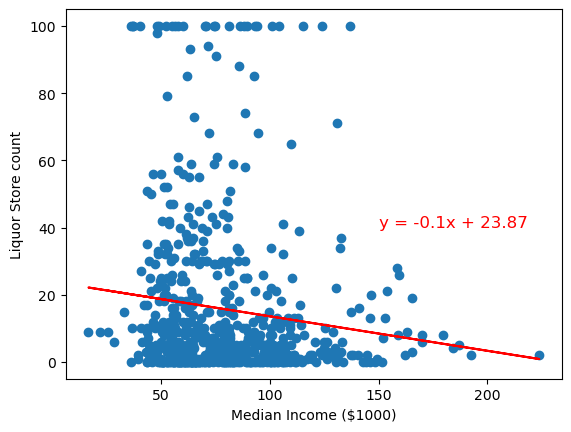

In [45]:
# Hypothesis 1: Income level correlates with liquor store count

# scatter plot and linear regression
x, y = df['Med_Inc']/1000, df['Lqr_Str'] 

plt.scatter(x, y)

from scipy.stats import linregress
(slp, intcp, r, p, se) = linregress(x, y)
reg = x * slp + intcp
if intcp>0:
    lin_eq = "y = " + str(round(slp,2)) + "x + " + str(round(intcp,2))
else:
    lin_eq = "y = " + str(round(slp,2)) + "x - " + str(abs(round(intcp,2)))

plt.plot(x, reg, "r-")
plt.annotate(lin_eq,(150, 40), fontsize=12, color="red")
plt.xlabel('Median Income ($1000)')
plt.ylabel('Liquor Store count')

plt.savefig("../images/Fig2_Inc_Lqr_linreg.png")

print(f'r-value is {r}')
plt.show()

Conclusion 1: Correlation between Income level and liquor store counts is negative and very weak based on linear regression.

In [44]:
# Hypothesis 2: Liquor store counts are significantly different between high and low income cities

# split data into 3 groups by income
cut1, cut2 = df['Med_Inc'].quantile(0.34), df['Med_Inc'].quantile(0.66)

df_low = df[df['Med_Inc']<=cut1]
df_high = df[df['Med_Inc']>cut2]
df_med = df[(df['Med_Inc']<=cut2) & (df['Med_Inc']>cut1)]

len(df), len(df_low), len(df_med), len(df_high)

(646, 220, 206, 220)

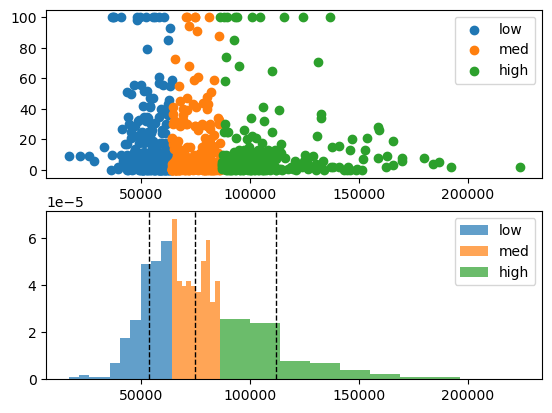

In [74]:
# visualization of the 3 groups
%matplotlib inline

plt.subplot(2, 1, 1)
plt.scatter(df_low['Med_Inc'], df_low['Lqr_Str'], label="low")
plt.scatter(df_med['Med_Inc'], df_med['Lqr_Str'], label="med")
plt.scatter(df_high['Med_Inc'], df_high['Lqr_Str'], label="high")
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(df_low['Med_Inc'], 10, density=True, alpha=0.7, label="low")
plt.hist(df_med['Med_Inc'], 10, density=True, alpha=0.7, label="med")
plt.hist(df_high['Med_Inc'], 10, density=True, alpha=0.7, label="high")
plt.axvline(df_low['Med_Inc'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(df_med['Med_Inc'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(df_high['Med_Inc'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()  

plt.savefig("../images/Fig3_Inc_groups.png")
    


In [70]:
# Statistics

# ANOVA
import scipy.stats as st
anova = st.f_oneway(df_low['Lqr_Str'], df_med['Lqr_Str'], df_high['Lqr_Str'])

# independent t test
t_low_high = st.ttest_ind(df_low['Lqr_Str'], df_high['Lqr_Str'], equal_var=False)
t_low_med = st.ttest_ind(df_low['Lqr_Str'], df_med['Lqr_Str'], equal_var=False)
t_med_high = st.ttest_ind(df_med['Lqr_Str'], df_high['Lqr_Str'], equal_var=False)

print(f'Average Liquor Store count:')
print(f"    low-{str(round(df_low['Lqr_Str'].mean(),2))}, med-{str(round(df_med['Lqr_Str'].mean(),2))} and high-{str(round(df_high['Lqr_Str'].mean(),2))}")
print('')
print(f'ANOVA: {anova}')
print('')
print(f'Independent t test:')
print(f'    low vs high: {t_low_high}')
print(f'    low vs med: {t_low_med}')
print(f'    med vs high: {t_med_high}')

Average Liquor Store count:
    low-19.01, med-15.14 and high-12.7

ANOVA: F_onewayResult(statistic=3.8614366023805475, pvalue=0.021527343366223577)

Independent t test:
    low vs high: TtestResult(statistic=2.6822364332230983, pvalue=0.007593452002092309, df=432.208063973875)
    low vs med: TtestResult(statistic=1.6429786569550338, pvalue=0.10113338047799914, df=421.3291245835345)
    med vs high: TtestResult(statistic=1.1009380850278856, pvalue=0.2715490340458595, df=423.4436307893415)


Conclusion 2: Liquor store counts are significantly different among the 3 groups.
But if only compare 2 groups, only the difference between low and high groups are statistically significant